In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

2024-08-05 13:44:46.167754: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-05 13:44:46.167863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 13:44:46.365071: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-05 13:44:46.760591: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-05 13:44:48.864525: W tensorflow/compiler/tf2

Benign Images


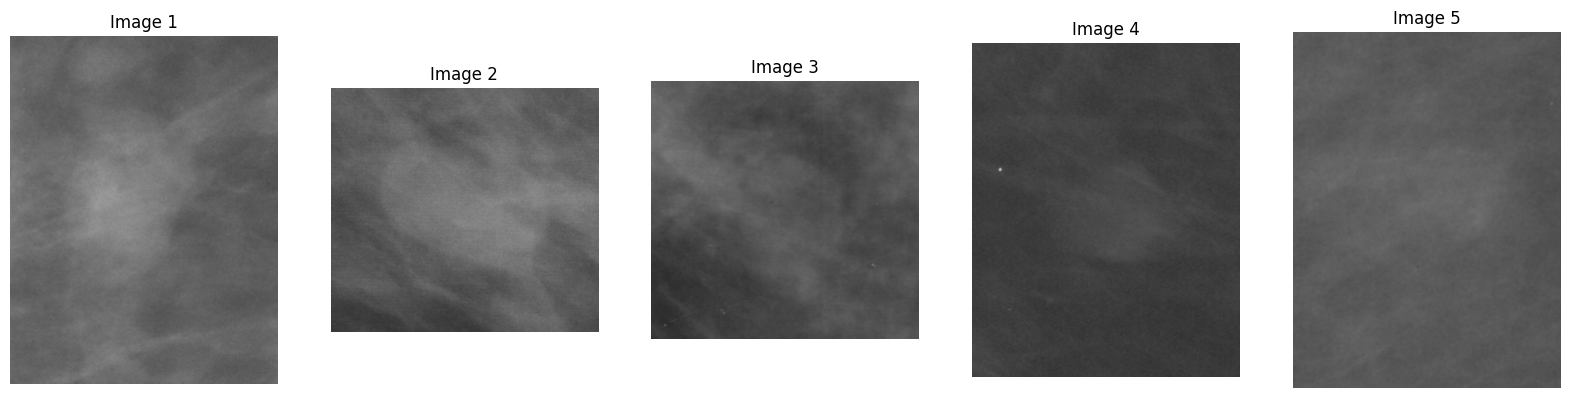

Malignant Images


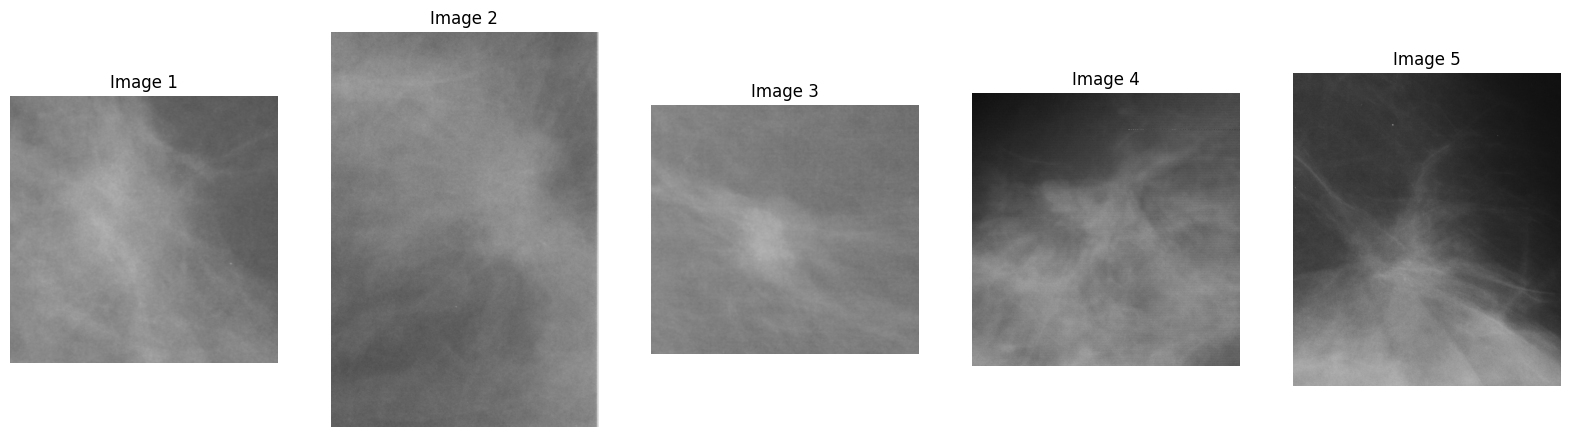

In [2]:

# Define paths
base_dir = '/home/ubuntu/BCS/Breast_Cancer_Segmentation/Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Function to load and display images using cv2
def load_and_display_images(folder_path, num_images=5):
    images = []
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.png'):
                img_path = os.path.join(subdir, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                images.append(img)
                if len(images) >= num_images:
                    break
        if len(images) >= num_images:
            break
    
    # Display images
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Visualize Benign and Malignant Images from Training Set
benign_folder = os.path.join(train_dir, 'benign')
malignant_folder = os.path.join(train_dir, 'malignant')

print("Benign Images")
load_and_display_images(benign_folder)

print("Malignant Images")
load_and_display_images(malignant_folder)

In [3]:
# Create ImageDataGenerators for augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and augment the data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(256, 256), batch_size=32, class_mode=None)
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(256, 256), batch_size=32, class_mode=None)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(256, 256), batch_size=32, class_mode=None)

Found 1370 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Found 198 images belonging to 2 classes.
Found 393 images belonging to 2 classes.


In [4]:
class AutoencoderDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_generator, batch_size):
        self.image_generator = image_generator
        self.batch_size = batch_size

    def __len__(self):
        return len(self.image_generator)

    def __getitem__(self, index):
        batch_x = self.image_generator[index]
        return batch_x, batch_x

# Create the custom data generators
train_autoencoder_generator = AutoencoderDataGenerator(train_generator, batch_size=32)
validation_autoencoder_generator = AutoencoderDataGenerator(validation_generator, batch_size=32)
test_autoencoder_generator = AutoencoderDataGenerator(test_generator, batch_size=32)

def unet_autoencoder(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = layers.Dropout(0.5)(pool1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = layers.Dropout(0.5)(pool2)

    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = layers.Dropout(0.5)(pool3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = layers.Dropout(0.5)(pool4)

    # Bottleneck
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(pool4)
    conv5 = layers.Conv2D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv5)
    conv5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2D(256, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge6)
    conv6 = layers.Conv2D(256, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv6)

    up7 = layers.Conv2D(128, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv7)

    up8 = layers.Conv2D(64, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv8)

    up9 = layers.Conv2D(32, 2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(merge9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))(conv9)
    conv10 = layers.Conv2D(3, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer='adam', loss='mean_squared_error')

    return model

autoencoder = unet_autoencoder()
autoencoder.summary()

2024-08-05 13:44:53.763555: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-05 13:44:54.309009: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-05 13:44:54.309335: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [5]:
# Add Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [6]:
# Training the autoencoder with early stopping
history = autoencoder.fit(train_autoencoder_generator, epochs=50, validation_data=validation_autoencoder_generator, callbacks=[early_stopping])


Epoch 1/50


2024-08-05 13:44:59.839114: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-08-05 13:45:01.274462: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-05 13:45:01.869597: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-05 13:45:03.370811: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-05 13:45:09.920019: I external/local_xla/xla/service/service.cc:168] XLA service 0x7e7c7b83e500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-05 13:45:09.920062: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Comp

43/43 [==============================] - 83s 1s/step - loss: 9.8452 - val_loss: 1.3154
Epoch 2/50
43/43 [==============================] - 37s 850ms/step - loss: 0.5380 - val_loss: 0.1771
Epoch 3/50
43/43 [==============================] - 35s 806ms/step - loss: 0.0943 - val_loss: 0.0513
Epoch 4/50
43/43 [==============================] - 35s 803ms/step - loss: 0.0321 - val_loss: 0.0260
Epoch 5/50
43/43 [==============================] - 35s 795ms/step - loss: 0.0167 - val_loss: 0.0190
Epoch 6/50
43/43 [==============================] - 35s 807ms/step - loss: 0.0111 - val_loss: 0.0167
Epoch 7/50
43/43 [==============================] - 34s 798ms/step - loss: 0.0082 - val_loss: 0.0154
Epoch 8/50
43/43 [==============================] - 35s 807ms/step - loss: 0.0061 - val_loss: 0.0143
Epoch 9/50
43/43 [==============================] - 36s 826ms/step - loss: 0.0047 - val_loss: 0.0132
Epoch 10/50
43/43 [==============================] - 35s 803ms/step - loss: 0.0033 - val_loss: 0.0121
Epo

In [7]:
# Save the trained model
autoencoder.save('breast_cancer_autoencoder.h5')

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


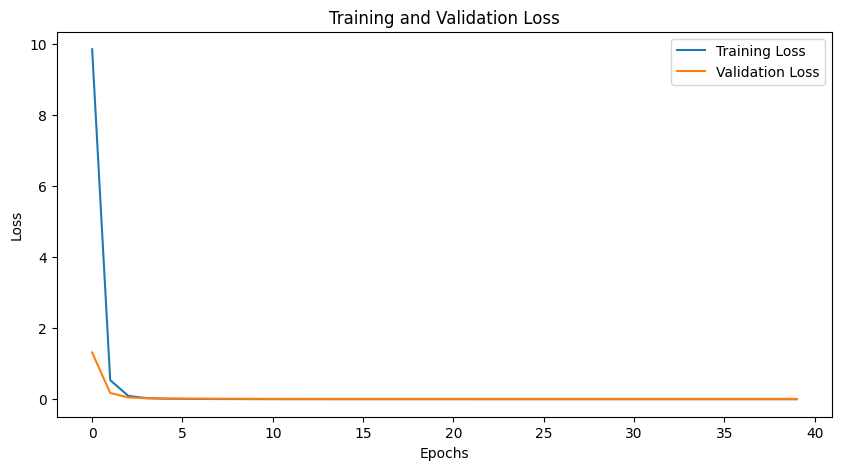

In [8]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 31ms/step


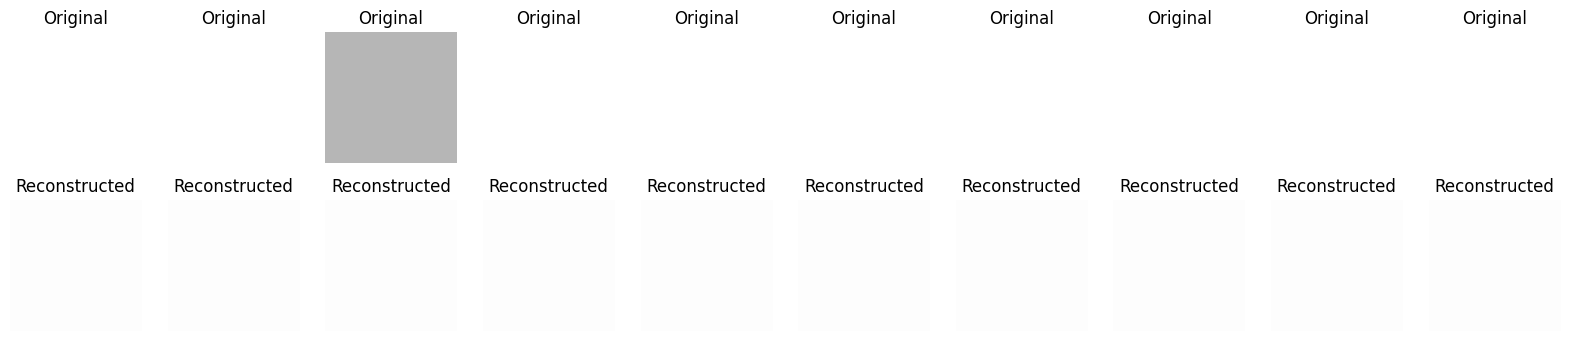

In [10]:
# Function to plot original and reconstructed images
def plot_reconstructed_images(original_images, reconstructed_images, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        reconstructed_image = reconstructed_images[i]
        if reconstructed_image.shape[2] == 1:  # If the image is grayscale
            reconstructed_image = reconstructed_image.squeeze()
        plt.imshow(reconstructed_image)
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Get a batch of images from the test set
test_images, _ = next(iter(test_autoencoder_generator))
# Get the reconstructed images
reconstructed_images = autoencoder.predict(test_images)

# Ensure the reconstructed images are in the range [0, 1]
reconstructed_images = np.clip(reconstructed_images, 0, 1)

# Plot original and reconstructed images
plot_reconstructed_images(test_images, reconstructed_images, n=10)


## 2

2024-08-06 09:09:57.063283: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 09:09:58.050992: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Benign Images


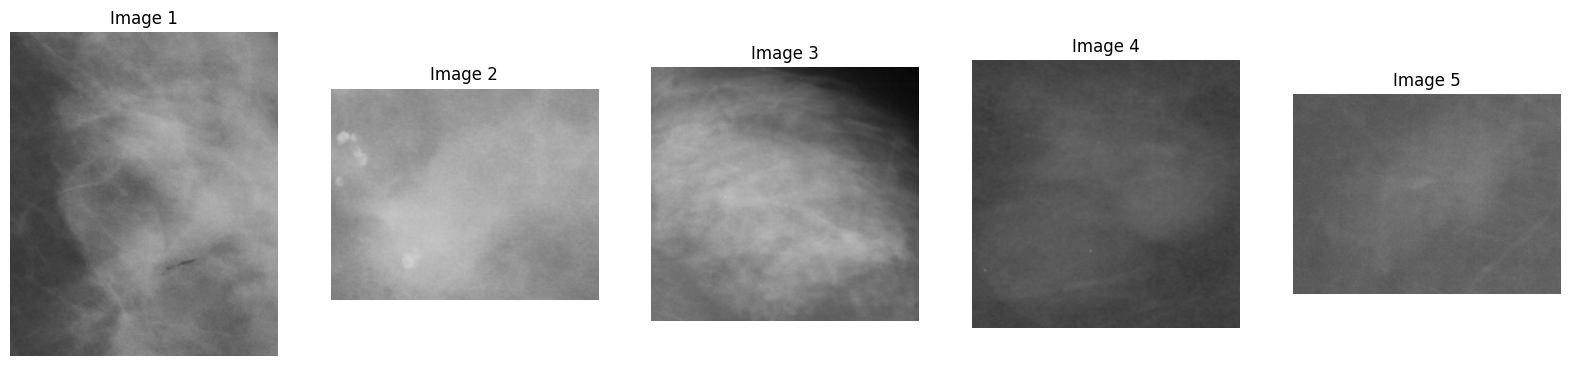

Malignant Images


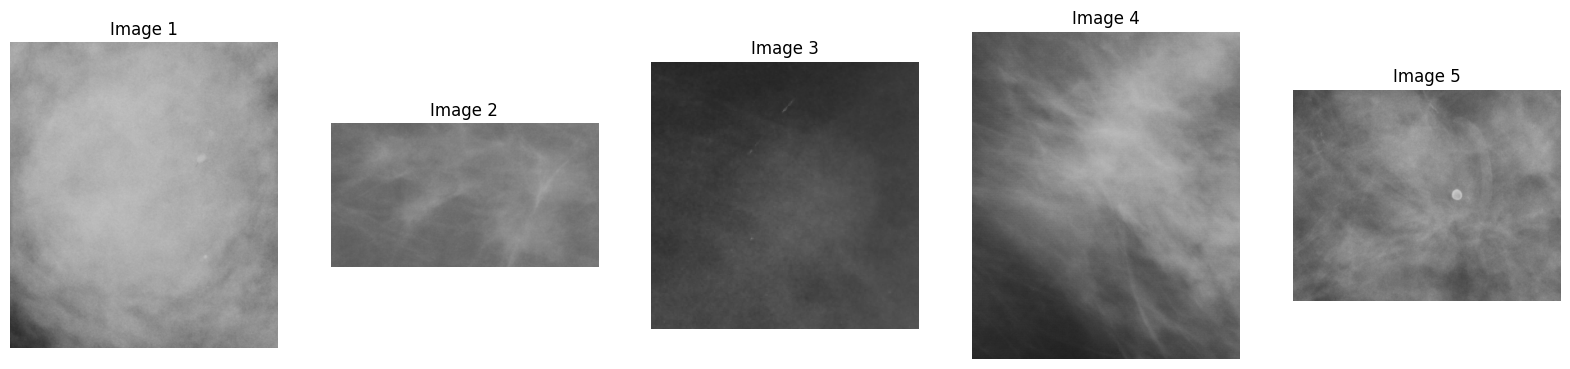

2024-08-06 09:10:19.850142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 09:10:19.886197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 09:10:19.886461: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

ResourceExhaustedError: {{function_node __wrapped__Mul_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Mul]

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Define paths
base_dir = '/home/ubuntu/BCS/Breast_Cancer_Segmentation/Dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# Function to load and display images using cv2
def load_and_display_images(folder_path, num_images=5):
    images = []
    for subdir, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.png'):
                img_path = os.path.join(subdir, file)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                images.append(img)
                if len(images) >= num_images:
                    break
        if len(images) >= num_images:
            break
    
    # Display images
    plt.figure(figsize=(20, 10))
    for i, img in enumerate(images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Image {i+1}")
        plt.axis('off')
    plt.show()

# Visualize Benign and Malignant Images from Training Set
benign_folder = os.path.join(train_dir, 'benign')
malignant_folder = os.path.join(train_dir, 'malignant')

print("Benign Images")
load_and_display_images(benign_folder)

print("Malignant Images")
load_and_display_images(malignant_folder)

# Define the U-Net model
def unet_model(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)

    # Encoding path
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c5)

    # Decoding path
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Function to preprocess images
def preprocess_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (256, 256))
    image = np.expand_dims(image, axis=-1)
    image = image / 255.0  # Normalize
    return image

# Function to load images from a folder
def load_images_from_folder(folder, num_images=None):
    images = []
    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.png'):
                img_path = os.path.join(subdir, file)
                img = cv2.imread(img_path)
                img = preprocess_image(img)
                images.append(img)
                if num_images and len(images) >= num_images:
                    break
        if num_images and len(images) >= num_images:
            break
    return np.array(images)

# Load and preprocess images
train_images = load_images_from_folder(train_dir)
validation_images = load_images_from_folder(validation_dir)

# Define and compile the U-Net model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
autoencoder = unet_model()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

history = autoencoder.fit(
    train_images, train_images,
    epochs=50,
    batch_size=2,  # Reduce batch size to fit in memory
    validation_data=(validation_images, validation_images),
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# Save the trained model
autoencoder.save('Main_breast_cancer_autoencoder.h5')

# Function to visualize anomalies
def visualize_anomalies(input_images, model, num_images=5):
    reconstructed_images = model.predict(input_images[:num_images])

    plt.figure(figsize=(20, 10))
    for i in range(num_images):
        original = input_images[i]
        reconstructed = reconstructed_images[i]

        anomaly = np.abs(original - reconstructed)
        anomaly = np.squeeze(anomaly)  # Remove single channel dimension

        plt.subplot(3, num_images, i+1)
        plt.imshow(np.squeeze(original), cmap='gray')
        plt.title(f"Original {i+1}")
        plt.axis('off')

        plt.subplot(3, num_images, i+num_images+1)
        plt.imshow(np.squeeze(reconstructed), cmap='gray')
        plt.title(f"Reconstructed {i+1}")
        plt.axis('off')

        plt.subplot(3, num_images, i+2*num_images+1)
        plt.imshow(anomaly, cmap='gray')
        plt.title(f"Anomaly {i+1}")
        plt.axis('off')

    plt.show()

# Visualize anomalies in validation images
visualize_anomalies(validation_images, autoencoder)